# Imports and installs

In [1]:
# #Only Rafa
# from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
import shap
from sklearn.metrics import r2_score, accuracy_score, precision_score

# Loading the Dataframe

## Merging the Seasons csv files (2019-2020 untill 2021-2022)

In [3]:
# Customise based on your path and folder organisation
print(os.listdir('../raw_data/All4'))

['spain_2019_2020_1.csv', 'italy_2020_2021_2.csv', 'italy_2021_2022_1.csv', 'italy_2021_2022_2.csv', 'spain_2020_2021_1.csv', 'spain_2020_2021_2.csv', 'scotland_2020_2021_2.csv', 'Turkey_2021_2022_1.csv', 'scotland_2020_2021_3.csv', 'scotland_2019_2020_1.csv', 'france_2021_2022_1.csv', 'germany_2021_2022_1.csv', 'belgium_2020_2021_1.csv', 'scotland_2021_2022_4.csv', 'scotland_2020_2021_1.csv', 'france_2019_2020_1.csv', 'germany_2021_2022_2.csv', 'germany_2019_2020_1.csv', 'england_2020_2021_3.csv', 'scotland_2019_2020_2.csv', 'italy_2019_2020_1.csv', 'scotland_2020_2021_4.csv', 'portugal_2021_2022_1.csv', 'france_2020_2021_2.csv', 'scotland_2021_2022_3.csv', 'england_2021_2022_3.csv', 'portugal_2019_2020_1.csv', 'Greece_2021_2022_1.csv', 'england_2020_2021_4.csv', 'england_2021_2022_4.csv', 'france_2020_2021_1.csv', 'germany_2020_2021_1.csv', 'scotland_2019_2020_4.csv', 'spain_2019_20220_2.csv', 'germany_2019_2020_2.csv', 'england_2019_2020_4.csv', 'scotland_2021_2022_1.csv', 'england_

In [4]:
# Concatenate all the CSVs

files = [file for file in os.listdir('../raw_data/All4') if file.endswith('.csv')]
data = pd.DataFrame()

for file in files:
    df = pd.read_csv('../raw_data/All4/' + file)
    df['country']=str(file)[0:2]
    df['country_division']=int(str(file)[-5:-4])
    data = pd.concat([data, df])

In [5]:
def get_data(league1, wall=False):
    if wall:
        data = pd.DataFrame()
        leagues = listdir(f'./../raw_data/')
        data = pd.DataFrame()
        for league in leagues:
            files = listdir(f'./../raw_data/{league}')
            for file in files:
                df = pd.read_csv((f'./../raw_data/{league}/'+file))
                df['country']=str(file)[0:2]
                data = pd.concat([data, df])
        return data
    else:
        files = [file for file in listdir(f'./../raw_data/{league1}')]
        data = pd.DataFrame()
        for file in files:
            df = pd.read_csv(f'./../raw_data/{league1}/'+file)
            data = pd.concat([data, df])
        return data

# Features Engineering

In [6]:
#Loading the function

def feature_engineering(data, b=20, binned=False):
    '''
    This function creates all the columns that will be needed to create the analysis 
    and return the dataframe with all this changes
    
    b is the number of bins that we want to work with. Our start value for b will be 20.
        '''
    #------------------------Number of Goals, Over and Under -----------------------------------
    
    # total number of goals = goals from the home team + goals from visiting team
    data['nb_goals']=data['FTHG']+data['FTAG']

    # boolean: true or false regarding whether they were more than 2.5 goals
    data['over_2.5_goals']=data['nb_goals']>2.5

    # boolean: true or false regarding whether they were less than 2.5 goals
    data['under_2.5_goals']=data['nb_goals']<2.5
    
    #-----------------------------Payout Opening ----------------------------------------------
    
    # payout under 2.5 for Average OPENING odds
    data['payout_avg_under_2.5'] = data['under_2.5_goals']*data['Avg<2.5']

    # payout over 2.5 for Average OPENING odds
    data['payout_avg_over_2.5'] = data['over_2.5_goals']*data['Avg>2.5']

    #payout UNDER 2.5 for PINACLE specifically
    data['payout_under_2.5_pinacle'] = data['under_2.5_goals']*data['P<2.5']

    #payout OVER 2.5 for PINACLE specifically
    data['payout_over_2.5_pinacle'] = data['over_2.5_goals']*data['P>2.5']

    #payout UNDER 2.5 for 365 specifically
    data['payout_under_2.5_365'] = data['under_2.5_goals']*data['B365<2.5']

    #payout OVER 2.5 for 365 specifically
    data['payout_over_2.5_365'] = data['over_2.5_goals']*data['B365>2.5']
    
    #------------------------------Payout Closing --------------------------------------------
    
    # payout under 2.5 for Average CLOSING odds
    data['payout_avg_under_closing_2.5'] = data['under_2.5_goals']*data['AvgC<2.5']

    # payout over 2.5 for Average CLOSING odds
    data['payout_avg_over_closing_2.5'] = data['over_2.5_goals']*data['AvgC>2.5']

    #payout UNDER 2.5 for PINACLE closing ddds specifically
    data['payout_under_2.5_pinacle_closing'] = data['under_2.5_goals']*data['PC<2.5']

    #payout OVER 2.5 for PINACLE closing odds specifically
    data['payout_over_2.5_pinacle_closing'] = data['over_2.5_goals']*data['PC>2.5']

    #payout UNDER 2.5 for 365 closing odds specifically
    data['payout_under_2.5_365_closing'] = data['under_2.5_goals']*data['B365C<2.5']

    #payout OVER 2.5 for 365 closing odds specifically
    data['payout_over_2.5_365_closing'] = data['over_2.5_goals']*data['B365C>2.5']
    
    #-------------------------- Implied Probability Opening ----------------------------------------
    
    #Implied Probability UNDER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability <2.5 avg']=1/data['Avg<2.5']*100

    #Implied Probability OVER 2.5 goals for for overall market opening odds (Avg) 
    data['Implied Probability >2.5 avg']=1/data['Avg>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE
    data['Implied Probability <2.5 pinacle']=1/data['P<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE
    data['Implied Probability >2.5 pinacle']=1/data['P>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365
    data['Implied Probability <2.5 365']=1/data['B365<2.5']*100

    #Implied Probability OVER 2.5 goals for 365
    data['Implied Probability >2.5 365']=1/data['B365>2.5']*100
    
    #------------------------- Implied Probability Closing -----------------------------------
    
    #Implied Probability UNDER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability <2.5 avg closing']=1/data['AvgC<2.5']*100

    #Implied Probability OVER 2.5 goals for overall market closing odds (AvgC)
    data['Implied Probability >2.5 avg closing']=1/data['AvgC>2.5']*100

    #Implied Probability UNDER 2.5 goals for PINACLE closing odds
    data['Implied Probability <2.5 pinacle closing']=1/data['PC<2.5']*100

    #Implied Probability OVER 2.5 goals for PINACLE closing odds
    data['Implied Probability >2.5 pinacle closing']=1/data['PC>2.5']*100

    #Implied Probability UNDER 2.5 goals for 365 closing odds
    data['Implied Probability <2.5 365 closing']=1/data['B365C<2.5']*100

    #Implied Probability OVER 2.5 goals for 365 closing odds
    data['Implied Probability >2.5 365 closing']=1/data['B365C>2.5']*100
    
    #---------------------------- Binning IP Opening -------------------------------------

    b=b
    bins = np.arange(0, 101, int(100/b))
    bins = bins.tolist()

    #Binning UNDER 2.5 Average Market opening odds
    data['binned <2.5 avg'] = pd.cut(data['Implied Probability <2.5 avg'], bins)

    #Binning Over 2.5 Average Market opening odds
    data['binned >2.5 avg'] = pd.cut(data['Implied Probability >2.5 avg'], bins)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned <2.5 pinacle'] = pd.cut(data['Implied Probability <2.5 pinacle'], bins)

    #Binned OVER 2.5 Pinnacle
    data['binned >2.5 pinacle'] = pd.cut(data['Implied Probability >2.5 pinacle'], bins)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned <2.5 365'] = pd.cut(data['Implied Probability <2.5 365'], bins)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned >2.5 365'] = pd.cut(data['Implied Probability >2.5 365'], bins)
    
    #----------------------------- Binning IP Closing ------------------------------------------------

    #Binning UNDER 2.5 Average Market closing odds
    data['binned <2.5 avg closing'] = pd.cut(data['Implied Probability <2.5 avg closing'], bins)

    #Binning OVER 2.5 Average Market closing odds
    data['binned >2.5 avg closing'] = pd.cut(data['Implied Probability >2.5 avg closing'], bins)

    #Binned UNDER 2.5 Pinnacle closing odds
    data['binned <2.5 pinacle closing'] = pd.cut(data['Implied Probability <2.5 pinacle closing'], bins)

    #Binned OVER 2.5 Pinnacle CLOSING odds
    data['binned >2.5 pinacle closing'] = pd.cut(data['Implied Probability >2.5 pinacle closing'], bins)

    #Binned UNDER 2.5 bet365 CLOSING odds
    data['binned <2.5 365 closing'] = pd.cut(data['Implied Probability <2.5 365 closing'], bins)

    #Binned OVER 2.5 bet365 CLOSING odds
    data['binned >2.5 365 closing'] = pd.cut(data['Implied Probability >2.5 365 closing'], bins)
    
    #---------------------------- Binning Odds Opening ----------------------------------------------------
    
    bins2 = [1, 1.5, 2, 3, 10]

    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg'] = pd.cut(data['Avg<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg'] = pd.cut(data['Avg>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle'] = pd.cut(data['P<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle'] = pd.cut(data['P>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365'] = pd.cut(data['B365<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365'] = pd.cut(data['B365>2.5'], bins2)
    
    #----------------------------- Binning Odds Closing ----------------------------------------------------------
    
    #Binning UNDER 2.5 Average Market opening odds
    data['binned odds <2.5 avg closing'] = pd.cut(data['AvgC<2.5'], bins2)

    #Binning Over 2.5 Average Market opening odds
    data['binned odds >2.5 avg closing'] = pd.cut(data['AvgC>2.5'], bins2)

    #Binned UNDER 2.5 Pinnacle opening odds
    data['binned odds <2.5 pinacle closing'] = pd.cut(data['PC<2.5'], bins2)

    #Binned OVER 2.5 Pinnacle
    data['binned odds >2.5 pinacle closing'] = pd.cut(data['PC>2.5'], bins2)

    #Binned UNDER 2.5 bet365 OPENING odds
    data['binned odds <2.5 365 closing'] = pd.cut(data['B365C<2.5'], bins2)

    #Binned OVER 2.5 bet365 OPENING odds
    data['binned odds >2.5 365 closing'] = pd.cut(data['B365C>2.5'], bins2)
    
    
    #----------------------------- Other Features from D3 ------------------------------------------------------
    
    data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
    data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
    data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
    data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
    data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
    data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
    
    #----------------------- Odds and probability of the home team scoring under 2.5 -------------------------------
    

    
    #------------------------------------ Cleaning the data ---------------------------------------------------------
    
    #data = data.dropna(subset=['HomeTeam', 'AwayTeam'], how='any')
    data = data[~data['HomeTeam'].isna()]
    data = data[~data['AwayTeam'].isna()]
    data = data[~data['PC>2.5'].isna()]
    data.drop(columns=['Referee','Unnamed: 105'], inplace=True) #, 'Unnamed: 105' 'Referee', 
    #data.dropna()
    
     #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 pinacle closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 pinacle closing']])
    data["1.0_to_1.5"], data["1.5_to_2.0"], data["2.0_to_3"], data["3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 pinacle closing', inplace=True)
    
    #-------------------------- OneHotEncoding the binned odds ------------------------------------------
   
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['binned odds <2.5 avg closing']])
    bins_encoded = ohe.transform(data[['binned odds <2.5 avg closing']])
    data["avg_1.0_to_1.5"], data["avg_1.5_to_2.0"], data["avg_2.0_to_3"], data["avg_3_to_10"] = bins_encoded.T
    data.drop(columns='binned odds <2.5 avg closing', inplace=True)
    
    
    #-------------------------- OneHotEncoding the binned countries ------------------------------------------

    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country']])
    bins_encoded = ohe.transform(data[['country']])
    data["country_1"], data["country_2"], data["country_3"], data["country_4"], data["country_5"],data["country_6"], data["country_7"], data["country_8"], data["country_9"], data["country_10"], data["country_11"] = bins_encoded.T
    data.drop(columns='country', inplace=True)

    #-------------------------- OneHotEncoding the binned country divisions ------------------------------------------
    
    ohe = OneHotEncoder(sparse=False) 
    ohe.fit(data[['country_division']])
    bins_encoded = ohe.transform(data[['country_division']])
    data["country_div_1"], data["country_div_2"], data["country_div_3"], data["country_div_4"] = bins_encoded.T
    #data.drop(columns='country_division', inplace=True)
    
    return data

In [7]:
#Running the function and creating the dataset data

data = feature_engineering(data, b=5)

In [8]:
## WE WILL NEED TO ADD ALL THOSE IN THE feature_engineering FUNCTION

## Adding the Year Feature 
data_date = data['Date']
data_time = data['Time']
data_date_2 = pd.to_datetime(data_date, dayfirst = True)
data_time_2 = pd.to_datetime(data_time, dayfirst = True)
data['month'] = pd.DatetimeIndex(data_date_2).month
data['month_after_July'] = data['month']>=7
data['year'] = pd.DatetimeIndex(data_date_2).year
data['year_2021_2022'] = data['year']>=2021
data['year_2022'] = data['year']>=2022
data['year_2020'] = data['year']==2020
data['season_21_22'] = data_date_2>='2021-09-01'
data['season_20_21'] = (data_date_2>='2020-09-01') & (data_date_2<'2021-09-01')
data['season_training2'] = (data_date_2<'2020-09-01')

data['hour'] = pd.DatetimeIndex(data_time_2).hour
data['game_starts_after_4pm']=data['hour']>=16

#Other features
data['Pin_pays_better_under_boolean'] = data['PC<2.5'] > data['AvgC<2.5']
data['Pin_pays_better_under_difference'] = data['PC<2.5'] / data['AvgC<2.5']
data['%vig_p'] = (1 - (1 / (1/data['PC>2.5'] + 1/data['PC<2.5'])))*100
data['%vig_p_bool'] = data['%vig_p']>3.3
data['%vig_avg'] = (1 - (1 / (1/data['AvgC>2.5'] + 1/data['AvgC<2.5'])))*100
data['%vig_avg_bool'] = data['%vig_avg']>5.4
data['PC<2.5_P_boolean'] = data['PC<2.5'] < data['P<2.5']
data['PC<2.5_P_relative_diff'] = data['PC<2.5'] / data['P<2.5']
data['MaxC>2.5_AvgC_relative_diff'] = data['MaxC>2.5']/data['AvgC>2.5']
data['Market_consensus'] = data['MaxC>2.5_AvgC_relative_diff']<1.05

In [9]:
data['month_number']=data['month']
data['month_number_ratio']=data['month']/12

In [10]:
data['year_number'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})
data['year_number_ratio'] = data['year'].map({2019:1, 2020:2, 2021:3, 2022:4})/4
data['year_number_month_ratio'] = data['year_number']+data['month_number_ratio']
data['year_number_month_decimal'] = data['year_number']+data['month_number']/10

In [11]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['year_number']])
bins_encoded = ohe.transform(data[['year_number']])
data["year_1"], data["year_2"], data["year_3"], data["year_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [12]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['month_number']])
bins_encoded = ohe.transform(data[['month_number']])
data["month_1"], data["month_2"], data["month_3"], data["month_4"], data["month_5"], data["month_6"], data["month_7"], data["month_8"], data["month_9"], data["month_10"], data["month_11"], data["month_12"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [13]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [14]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['game_starts_after_4pm']])
bins_encoded = ohe.transform(data[['game_starts_after_4pm']])
data["game_starts_after_4pm_1"], data["game_starts_after_4pm_2"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [15]:
data['hour_number'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})
data['hour_number_2'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})
data['hour_number_2_ratio'] = data['hour'].map({10:1, 11:1, 12:1, 13:2, 14:2, 15:2, 16:3, 17:3, 18:3, 19:4, 20:4, 21:4})/4
data['hour_number_ratio'] = data['hour'].map({10:1, 11:2, 12:3, 13:4, 14:5, 15:6, 16:7, 17:8, 18:9, 19:10, 20:11, 21:12})/12

In [16]:
ohe = OneHotEncoder(sparse=False) 
ohe.fit(data[['hour_number_2']])
bins_encoded = ohe.transform(data[['hour_number_2']])
data["hour_group_1"], data["hour_group_2"], data["hour_group_3"], data["hour_group_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

In [17]:
data['PC<2.5']

data.rename(columns = {'PC<2.5':'PC_under_2.5'}, inplace = True)

In [18]:
#     ohe = OneHotEncoder(sparse=False) 
#     ohe.fit(data[["binned_odds"]])
#     bins_encoded = ohe.transform(data[["binned_odds"]])
#     data["bin_odds_1"], data["bin_odds_2"],data["bin_odds_3"], data["bin_odds_4"] = bins_encoded.T
   # data.drop(columns='country_division', inplace=True)

# Running the XGB model for under 2.5

In [21]:
# Creating the model dataset with relevant variables
data_linear_booleans_lean_P_under = data[['year_number','year_number_ratio','year_number_month_ratio','year_number_month_decimal','month_number','month_number_ratio','country_div_1','country_div_2','country_div_3','country_div_4','month_after_July','season_21_22','year_2020','game_starts_after_4pm','Market_consensus','%vig_p_bool','%vig_avg_bool','avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10','payout_under_2.5_pinacle_closing','year_1','year_2','year_3','year_4','month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','hour_number','hour_number_ratio','hour_number_2','hour_number_2_ratio',"game_starts_after_4pm_1","game_starts_after_4pm_2",'hour_group_1','hour_group_2','hour_group_3','hour_group_4','country_division','season_training2','season_20_21','payout_avg_under_closing_2.5']]

## Defining the function testing_models

In [22]:
# back up
def testing_models(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
        y_pred_xgb = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------    

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_avg_under_closing_2.5'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_avg_under_closing_2.5'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
        
        return y_test, y_train_0, y_pred_xgb, y_final_xgb 
        
        i=i+1
        

In [23]:
# results_lr_true = []
# results_lr_false = []

def testing_models_classifier(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0_classifier, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBClassifier()
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0_classifier) 
        
        #Make and store the predictions XGBoost
        y_pred_test = m.predict(X_test)
        y_pred_test_df = pd.DataFrame(y_pred_test,columns=['prediction'])
        y_pred_train = m.predict(X_train_0)
        y_pred_train_df = pd.DataFrame(y_pred_train)
        y_test_df = pd.DataFrame(y_test).reset_index()
        y_final_df = y_pred_test_df.copy()
        y_final_df['actual'] = y_test_df['payout_avg_under_closing_2.5']

        
        # accuracy
        accuracy_test = accuracy_score(y_test,y_pred_test)
        accuracy_train = accuracy_score(y_train_0_classifier,y_pred_train)
        
        # precision
        precision_test = precision_score(y_test,y_pred_test)
        precision_train = precision_score(y_train_0_classifier,y_pred_train)
    
  #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val
        
        #XGB
        #ind = np.arange(0, len(y_pred_test_df))
        #ind = ind.tolist()
        #y_xgb_df['ind'] = ind
        #y_pred_test_df['ind'] = ind
        
        #Defining the variable bet_opp based on the y_pred of the XGB

        y_final_df['payout_avg_under_closing_2.5'] = y_test_0.loc[y_test.index].reset_index()['payout_avg_under_closing_2.5']
        #import ipdb; ipdb.set_trace()
        #y_final_df['payout_avg_under_closing_2.5'] = 0

        result_False = y_final_df[y_final_df['prediction']==False]['payout_avg_under_closing_2.5'].mean()
        result_True = y_final_df[y_final_df['prediction']==True]['payout_avg_under_closing_2.5'].mean()
        
        results_False.append(result_False)
        results_True.append(result_True)
        
        i=i+1
        
    return accuracy_test, accuracy_train, precision_train, precision_test, y_final_df
        
        
        

In [31]:
accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(10)

In [33]:
accuracy_test, accuracy_train, precision_train, precision_test

(0.5586996799730504,
 0.5889999301139143,
 0.5811435660313522,
 0.5491886409736308)

In [25]:
# results_lr_true = []
# results_lr_false = []

def testing_models2(iterations):   
    
    i=0
    
    while i < iterations:
        # Split into Train/Test
        #X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.3) # Split into Train/Test
        X_train, X_test, y_train, y_test = train_test_split(X_test_0, y_test_0, test_size=test_size_0) # Split into Train/Test

            #------------------------Run the Models -----------------------------------

        #Initiate XGBoost
        m = 0
        m = xgb.XGBRegressor()
        
        #Rename columns for XGBoost to run
        ##X_test.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        ##X_train.rename(columns = {'PC<2.5_P_boolean':'PC_under_2.5_P_boolean'}, inplace = True)
        
        #Fit XGBoost
        m.fit(X_train_0,y_train_0) 

        #Make and store the predictions XGBoost
        y_pred_xgb_vector = m.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb_vector)
        y_pred_xgb_train_vector = m.predict(X_train_0)
        y_pred_xgb_train = pd.DataFrame(y_pred_xgb_train_vector)
        r2_score_test = r2_score(y_test,y_pred_xgb_vector)
        r2_score_train = r2_score(y_train_0,y_pred_xgb_train_vector)

            #------------------------Creating the bins for the predictions for both models -----------------------------------
        #Function to replace bin with default value when it is null
        def ifnull(var, val):
          if var > 0:
            return var
          return val

        #XGB bins
        y_pred_xgb_under_0_median = y_pred_xgb[y_pred_xgb<0].median()
        y_pred_xgb_under_0_min = y_pred_xgb[y_pred_xgb<0].min()
        y_pred_xgb_over_0_median = ifnull(y_pred_xgb[0][y_pred_xgb[0]>0].median(),0.05)

            #------------------------Betting decisions for both models -----------------------------------

        #XGB
        bins3_xgb = [y_pred_xgb_under_0_min[0]-0.0000002, y_pred_xgb_under_0_median[0]-0.0000001, 0, y_pred_xgb_over_0_median+0.0000001, 1] #int(y_pred_xgb_over_0_median[0])
        y_xgb_df = pd.DataFrame(y_test)
        y_pred_xgb_df = pd.DataFrame(y_pred_xgb)
        y_pred_xgb_df["binned_pred"] = pd.cut(y_pred_xgb_df[0], bins3_xgb)
        y_pred_xgb_df["binned_pred_bin_1"] = y_pred_xgb_df[0]<y_pred_xgb_under_0_median[0]-0.0000001
        y_pred_xgb_df["binned_pred_bin_2"] = (y_pred_xgb_df[0]>y_pred_xgb_under_0_median[0]-0.0000001) & (y_pred_xgb_df[0]<0)
        y_pred_xgb_df["binned_pred_bin_3"] = (y_pred_xgb_df[0]>0) & (y_pred_xgb_df[0]<y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["binned_pred_bin_4"] = (y_pred_xgb_df[0]>y_pred_xgb_over_0_median+0.0000001)
        y_pred_xgb_df["bin_number"] = y_pred_xgb_df["binned_pred_bin_1"]*1 + y_pred_xgb_df["binned_pred_bin_2"]*2 + y_pred_xgb_df["binned_pred_bin_3"]*3 + y_pred_xgb_df["binned_pred_bin_4"]*4     
        ind = np.arange(0, len(y_pred_xgb_df))
        ind = ind.tolist()
        y_xgb_df['ind'] = ind
        y_pred_xgb_df['ind'] = ind
        y_final_xgb = y_xgb_df.merge(y_pred_xgb_df, on="ind")#, on = "axis")#, how = "inner")
        
        #Defining the variable bet_opp based on the y_pred of the XGB
        y_final_xgb['bet_opp']=y_final_xgb[0]>0

            #------------------------Getting the results based on predictions -----------------------------------     

        #XGB
        #xgb_count = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].count()
        #xgb_mean = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].mean()
        #xgb_results = y_final_xgb.groupby('bet_opp')['payout_under_2.5_pinacle_closing'].agg(["mean", "count"])
        xgb_results_False = y_final_xgb[y_final_xgb['bet_opp']==False]['payout_avg_under_closing_2.5'].mean()
        xgb_results_True = y_final_xgb[y_final_xgb['bet_opp']==True]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_1 = y_final_xgb[y_final_xgb['bin_number']==1]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_2 = y_final_xgb[y_final_xgb['bin_number']==2]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_3 = y_final_xgb[y_final_xgb['bin_number']==3]['payout_avg_under_closing_2.5'].mean()
        xgb_results_bin_4 = y_final_xgb[y_final_xgb['bin_number']==4]['payout_avg_under_closing_2.5'].mean()
        
        results_xgb_false.append(xgb_results_False)
        results_xgb_true.append(xgb_results_True)
        results_xgb_1.append(xgb_results_bin_1)
        results_xgb_2.append(xgb_results_bin_2)
        results_xgb_3.append(xgb_results_bin_3)
        results_xgb_4.append(xgb_results_bin_4)
        
        return y_test, y_train_0, y_pred_xgb, y_final_xgb, r2_score_test, r2_score_train
        
        i=i+1
        

## Running the function testing_models 

In [26]:
#reset the indices
data_linear_booleans_lean_P_under.reset_index(inplace=True, drop=True)

# Select here the variables you want to include in the testing
#'hour_number','hour_number_ratio',"hour_10","hour_11","hour_12","hour_13","hour_14","hour_15","hour_16","hour_17","hour_18","hour_19","hour_20","hour_21",'hour_number','hour_number_ratio','hour_number_2_ratio'
X_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10']]#,'year_number_ratio','month_number_ratio']]
X_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True][['country_div_1','country_div_2','country_div_3','country_div_4','%vig_avg_bool','Market_consensus','year_number',"game_starts_after_4pm_2","game_starts_after_4pm_1",'avg_1.0_to_1.5','avg_1.5_to_2.0','avg_2.0_to_3','avg_3_to_10']]#,'year_number_ratio','month_number_ratio']]
y_train_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_avg_under_closing_2.5']-1
y_test_0 = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_avg_under_closing_2.5']-1

#creating the classifier model
y_test_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==True]['payout_avg_under_closing_2.5']!=0
y_train_0_classifier = data_linear_booleans_lean_P_under[data_linear_booleans_lean_P_under['season_21_22']==False]['payout_avg_under_closing_2.5']!=0

#div_1',country_div_1','country_div_2','country_div_3','country_div_4

In [27]:
# Run the function testing_models
results_xgb_true = [] 
results_xgb_false = []
results_xgb_1=[]
results_xgb_2=[]
results_xgb_3=[]
results_xgb_4=[]
results_False=[]
results_True=[]

In [28]:
test_size_0=0.90
testing_models_classifier(100)
accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(10)

KeyboardInterrupt: 

In [34]:
def checking_model_classifier_results(n=10):
    
    #empty_lists
    results_False=[]
    results_True=[]
    
    #empty_lists
    accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = testing_models_classifier(n)
    median_results_bad_bets = np.median(np.array(results_False))
    median_results_good_bets = np.median(np.array(results_True))
    
    #Plotting the results of the XGB
    sns.histplot(results_True,kde=True,bins=20,color='green')
    sns.histplot(results_False,kde=True,bins=20,color='red')
    
    return median_results_bad_bets, median_results_good_bets, accuracy_test, accuracy_train, precision_train, precision_test, y_final_df

Mean of empty slice.
invalid value encountered in double_scalars


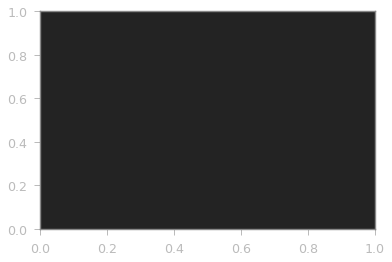

In [37]:
median_results_bad_bets, median_results_good_bets, accuracy_test, accuracy_train, precision_train, precision_test, y_final_df = checking_model_classifier_results(n=10)

In [36]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_xgb_false))
median_results_good_bets = np.median(np.array(results_xgb_true))

Mean of empty slice.
invalid value encountered in double_scalars


In [ ]:
results_True

In [ ]:
results_False

In [ ]:
# Results of the X tests with XGB (that you ran with the function testing_models)
median_results_bad_bets = np.median(np.array(results_False))
median_results_good_bets = np.median(np.array(results_True))

In [ ]:
median_results_bad_bets

In [ ]:
# Delta variable (gap between bad and good group) is the variable we aim to maximise with our features and models fine-tuning, the greater the better!
delta = np.median(np.array(median_results_good_bets))-np.median(np.array(median_results_bad_bets))

In [ ]:
delta_extremes = np.median(np.array(results_xgb_4))-np.median(np.array(results_xgb_1))

In [ ]:
best_results = np.median(np.array(results_xgb_4))

In [ ]:
worse_results = np.median(np.array(results_xgb_1))

In [ ]:
print(delta, delta_extremes)

In [ ]:
results_xgb_false

In [ ]:
# Plotting the results of the XGB
sns.histplot(results_True,kde=True,bins=20,color='green')
sns.histplot(results_False,kde=True,bins=20,color='red')

In [ ]:
# Plotting the results of the XGB
sns.histplot(results_xgb_true,kde=True,bins=20,color='green')
sns.histplot(results_xgb_false,kde=True,bins=20,color='red')

In [ ]:
# Plotting the results of the XGB
sns.histplot(results_xgb_1,kde=True,bins=20,color='red')
sns.histplot(results_xgb_2,kde=True,bins=20,color='orange')
sns.histplot(results_xgb_3,kde=True,bins=20,color='grey')
sns.histplot(results_xgb_4,kde=True,bins=20,color='green')

# [SKIP] Comments regarding results of the tests we ran and Next Steps [SKIP]

In [ ]:
## Comments

# baseline = 0.008297694850435258 (all features)

# delta without Joao features = 0.014419296789770412 => F:-0.029970666611150436 and T:-0.015551369821380024
# --> WE REMOVE JOAO FEATURE

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the odds buckets = -0.009317543146000251 => F:-0.022611272813043187 and T:-0.028804787343669917
# --> WE KEEP THE ODDS BUCKETS

# delta when removing the countries and divisions = 0.004795286566703704
# --> WE KEEP THE COUNTRIES AND DIVISIONS

# delta when removing the divisions but keeping the countries = 0.008380480363148559 (worsening)
# delta when removing the countries but keeping the divisions = 0.02259680830123266 (best score ever)
# --> WE KEEP THE DIVSIONS AND REMOVE THE COUNTRIES

# delta when removing the 'month_after_July': 0.013657154854343441 DECREASED A LOT! We keep month after July
# year 2020_2021 = 0.012829398919170131 DECREASED A LOT! 
# TIME MATTERS!! We need months, years, time

# New basline: 0.023917075840908224

#'Pin pays better' does not improve the baseline and we remove it

#'Market_consensus' MATTERS we keep it

#VIG matters

# We should remove the P<PC variable
# BEST DELTA: 0.03151890594630853


In [ ]:
# Next steps:

## Time: Further explore how to optimise the features of time (years, months, hours, etc.)
## Odds: Further explore how to optimise the odds buckets (different bins, min-max scaling)
## VIG + Mkt Consensus: Further explore how to optimise VIG + Market consensus

In [ ]:
m.feature_importances

# [SKIP] Other models + stats package we could use [SKIP]

In [ ]:
# Random Forest

In [ ]:
my_model = xgb.XGBRegressor()
my_model.fit(X_train_0,y_train_0) 
        
        #Make and store the predictions XGBoost
       # y_pred_xgb = m.predict(X_test)
       # y_pred_xgb = pd.DataFrame(y_pred_xgb)

In [ ]:
#my_model = RandomForestRegressor(random_state=0).fit(X_step_joao, y)

In [ ]:
y_pred = my_model.predict(X_test_0)

In [ ]:
# SHAP values

In [ ]:
#import shap  # package used to calculate Shap values

# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(X_test_0)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test_0)

#- Vertical location shows what feature it is depicting
#- Color shows whether that feature was high or low for that row of the dataset
#- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

In [ ]:
shap.summary_plot(shap_values, X_test_0, plot_type="bar")